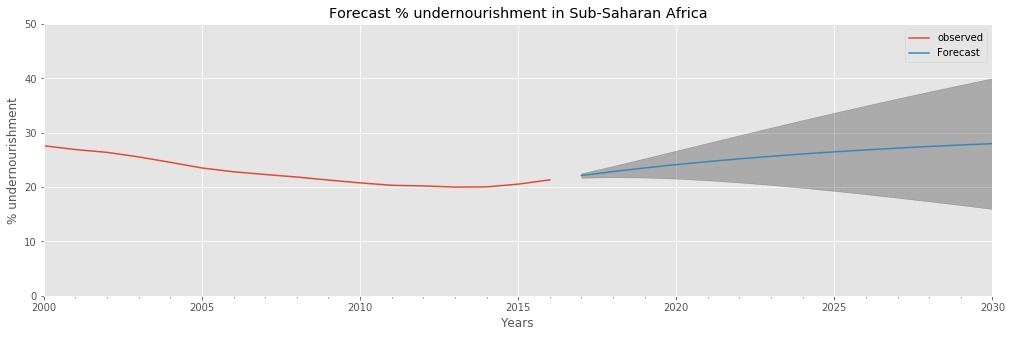

In [5]:
# stuff I had to import for this chart
from datetime import datetime
import warnings
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta

warnings.filterwarnings("ignore") 

#Create dataframe for undernourishment in only Sub-Saharan Africa
dfu = df[df["Indicator Code"] == 'SN.ITK.DEFC.ZS']
dfu = dfu[dfu["Country Name"] == 'Sub-Saharan Africa']
dfu = dfu.dropna()
con = dfu['Years']
dfu['Years']=pd.to_datetime(dfu['Years'])
dfu.set_index('Years', inplace=True)
ts = dfu['value']

#Autocorrelation of the data
lnts = np.log(ts)
acf_1 = acf(lnts)
test_df = pd.DataFrame([acf_1]).T
test_df.colums = ['Autocorrelation']
test_df.index += 1 
#test_df.plot(kind = 'bar')

#Partial Autocorrelation of the data
pacf_1 = pacf(lnts)
test2_df = pd.DataFrame([pacf_1]).T
test2_df.colums = ['Partial Autocorrelation']
test2_df.index += 1 
#test2_df.plot(kind = 'bar')

#The ARIMA model
model = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(0,0,0), seasonal_order=(1,1,1,1))
results = model.fit()
#print(results.summary())

#Forecast the undernourishment with the confident intervals
forecast = results.predict(start = 17, end = 30 , dynamic= True)
test = results.get_forecast(steps=14)
ci = test.conf_int()

#plot the forecast
ax = ts.plot(label='observed',figsize=(17,5))
forecast.plot(ax=ax, label='Forecast')
ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Years')
ax.set_ylabel('% undernourishment')
plt.title('Forecast % undernourishment in Sub-Saharan Africa')
plt.legend()
plt.axis([30,60,0,50])
plt.show()

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
import plotly.plotly as py
import plotly.graph_objs as go
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
import os
from dateutil.relativedelta import relativedelta

plt.style.use('ggplot')

In [2]:
os.chdir('/Users/Martijn/Documents/GitHub/data')

In [3]:
#reading in the data
df_code = pd.read_csv("countriescodes.csv", sep = ",", encoding = 'latin-1')
df_wdi = pd.read_csv("WDI/WDIData.csv")

#creating a dataframe with only countries in Sub-Saharan Africa, the region Sub-Saharan Africa and the World.
df_code = df_code[df_code['sub-region'] == "Sub-Saharan Africa"]["alpha-3"]
region = pd.Series(["SSF","WLD"]) 
df_code = df_code.append(region)
df_wdi = df_wdi[df_wdi["Country Code"].isin(df_code)]

# Set the years from colums to rows
df = pd.melt(df_wdi,id_vars =["Country Name","Country Code","Indicator Name","Indicator Code"],
          var_name = "Years")
# Sort the values first by Country Name and then by Years
df = df.sort_values(["Country Name", "Years"])

In [27]:
def data_plot(indicator_code,title,ytitle,yrange):
    df_und = df[df["Indicator Code"] == indicator_code]
    df_und = df_und.dropna()
    x = df_und[df_und["Country Name"] == 'World']["Years"]
    y1 = df_und[df_und["Country Name"] == 'World']["value"]
    y2 = df_und[df_und["Country Name"] == 'Sub-Saharan Africa']["value"]

    trace0 = go.Scatter(
        x = x,
        y = y1,
        mode = "lines + markers",
        name = "World"
        )
    trace1 = go.Scatter(
        x = x,
        y = y2,
        mode = "lines + markers",
        name = "Sub-Saharan Africa"
    )

    data = [trace0,trace1]
    
    layout = dict(title = title,
              xaxis = dict(title = 'Years'),
              yaxis = dict(title = ytitle,
                          range = [0,yrange]),
              )

    fig = dict(data=data, layout=layout)
    plot = py.iplot(fig, filename='line-mode')
    return plot

In [29]:
data_plot(indicator_code ='SN.ITK.DEFC.ZS',
          title = 'Undernourishment in Sub-Saharan Africa vs. the World',
          ytitle = '% Undernourishment',
          yrange = 30)

In [30]:
data_plot(indicator_code = 'AG.YLD.CREL.KG',
          title = 'Cereal Yield in Sub-Saharan Africa vs. the World',
          ytitle = 'Cereal Yield (kg per hectare)',
          yrange = 4500)

In [13]:
def create_map_undernourishment(year):
    df_map = df[df["Indicator Code"] == 'SN.ITK.DEFC.ZS']
    df_map = df_map[df_map["Years"] == year]

    scl = [[0.0, 'rgb(255,127,80)'],[0.2, 'rgb(255,99,71)'],[0.4, 'rgb(255,0,0)'],\
            [0.6, 'rgb(220,20,60)'],[1, 'rgb(178,34,34)']]

    df_map['text'] = df_map['Country Name']

    data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_map['Country Code'],
        z = df_map['value'],
        locationmode = 'ISO-3',
        text = df_map['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 1
            ) ),
        colorbar = dict(
            title = "% Undernourishment")
        ) ]

    layout = dict(
        title = 'Undernourishment in Sub-Saharan Africa %year%',
        geo = dict(
            scope='africa',
            showlakes = True,
            lakecolor = 'rgb(135,206,235)',
            showland = True,
            landcolor = 'rgb(220,220,220)')
             )
    
    fig = dict( data=data, layout=layout )
    plot = py.iplot( fig, filename='d3-cloropleth-map' )
    return plot

In [14]:
create_map_undernourishment('2000')

PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per 24h period. If you need to raise your daily limit, please consider upgrading to a paid plan
(see: https://plot.ly/products/cloud ).

In [15]:
create_map_undernourishment('2016')

PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per 24h period. If you need to raise your daily limit, please consider upgrading to a paid plan
(see: https://plot.ly/products/cloud ).